# Loading data with PyTorch
In this notebook we will investigate a few different ways to handle data with PyTorch on Alvis.

## Using your own data
In many cases you have a dataset in mind that you've already acquired and are keeping in your home folder or perhaps more probable in a storage project.

When it comes to using datasets in training datasets the most efficient approach that we have found to work on Alvis is to use utilities to directly stream data from uncompressed tar-archives or zip-archives (though highly compressed zip files can also sometimes be slow).

In this section we will use the tiny-ImageNet dataset in `/mimer/NOBACKUP/Datasets` but with the hope that you can adapt it to any dataset that you have in your project storage. First let us take a look at the dataset.

### Investigating the contents
Let's take a look at what is contained in this archive.

In [1]:
from torchdata.datapipes.iter import FileOpener

# Look at the first five files to get a sense of the structure
path_to_dataset = '/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip'
fileopener = FileOpener([path_to_dataset], mode='b')
for ix, (filename, stream) in enumerate(fileopener.load_from_zip()):
    print(filename)
    if ix >= 5:
        break

/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/words.txt
/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/wnids.txt
/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/test/images/test_1860.JPEG
/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/test/images/test_613.JPEG
/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/test/images/test_6272.JPEG
/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/test/images/test_2289.JPEG


***NOTE:*** Investigating files like this can be quite slow if the archives are very large. Looking at the first few files are fast and can be good to get a sense of the file, but you don't want to have to search through them every time. If there is a README in connection with the dataset it is wise to take a look at it. Furthermore, you might want to note down the structure inside the archive yourself if it isn't in the README.

In [2]:
# Let's take a look at one of the txt files next
datapipe = fileopener.load_from_zip()
datapipe = datapipe.filter(lambda d: d[0].endswith('wnids.txt'))
for fn, txtfile in datapipe:
    print(fn)
    wnids = txtfile.read().decode('utf-8').split()
    print(wnids)
    break

/mimer/NOBACKUP/Datasets/tiny-imagenet-200/tiny-imagenet-200.zip/tiny-imagenet-200/wnids.txt
['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n0291706

This will later be used as the labels for our task.

Note that we could have used built in utilties or shell utlities for this as well. For example:

In [3]:
import zipfile

ziphandle = zipfile.ZipFile(path_to_dataset)

# Count the number of training files in the dataset
len([fn for fn in ziphandle.namelist() if 'train' in fn and fn.endswith('.JPEG')])

100000

This is fast for zip-files as they have information about all of its members easily retriveable for a tarfile you would have to traverse the entire archive (with e.g. `tarfile.TarFile.getmembers`).

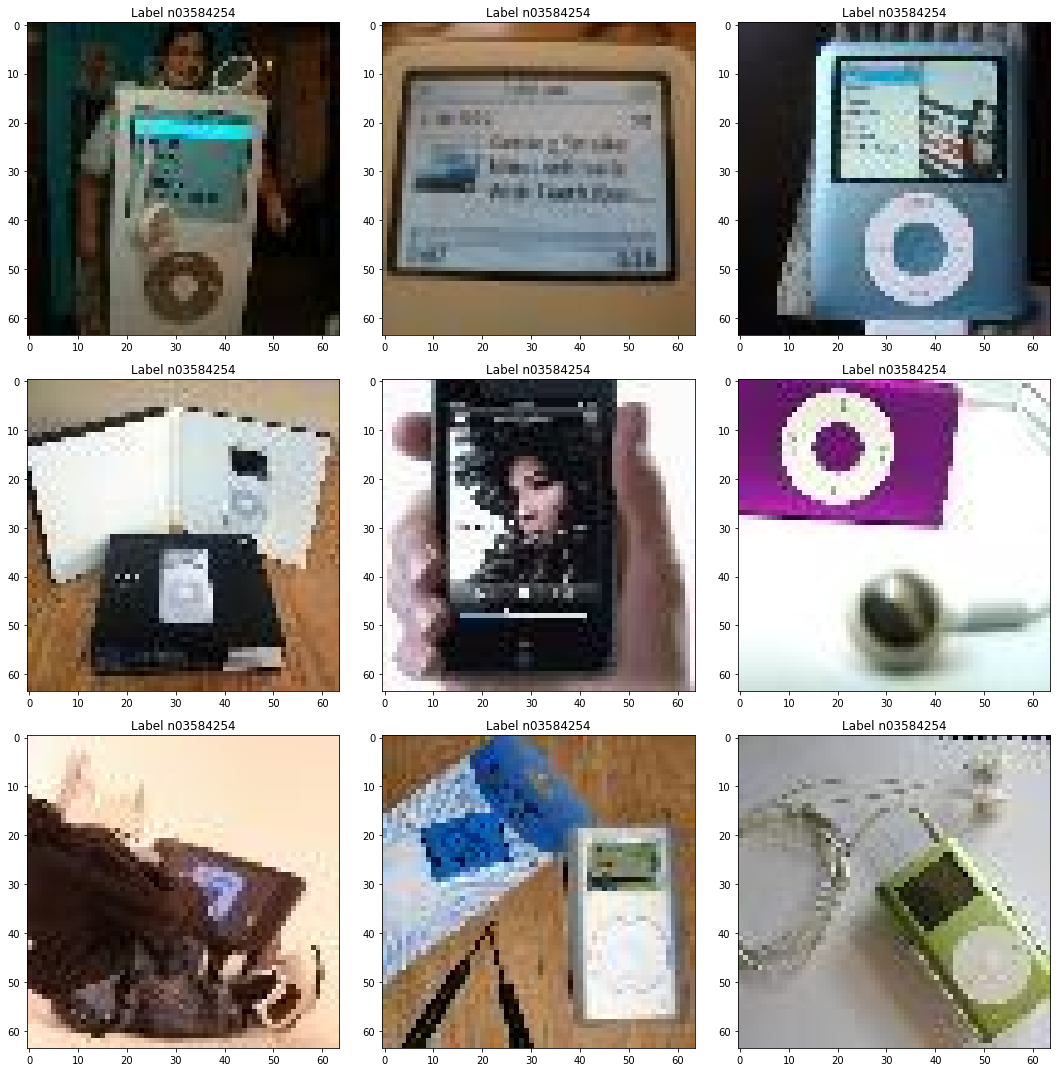

In [4]:
from fnmatch import fnmatch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Construct datapipe to load images
datapipe = fileopener.load_from_zip()
def train_image_filter(datum):
    filename, _ = datum
    return fnmatch(filename, '*train*.JPEG')
datapipe = datapipe.filter(train_image_filter)


# Visualize images
fig, ax_grid = plt.subplots(3, 3, figsize=(15, 15))
for ax, (fn, stream) in zip(ax_grid.flatten(), datapipe):
    # Get path to file and label
    label = fn.split("/")[-1].split('_')[0]
    
    # Add to axis
    img = plt.imread(stream)
    ax.imshow(img)
    ax.set_title(f'Label {label}')
    
fig.tight_layout()

It might be worth noting that the image labels are listed in wnids.txt that can be found in the archive.

### Training a classifier from this data
Now we have some understanding of what the database does and we are ready to do some ML on it.

First we will define our machine learning model.

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [6]:
# We will use torch.hub to load a pretrained model
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
#preprocessing_utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# We freeze all parameters except the last layer
freeze_blocks = [efficientnet.stem] + [
    layer
    for layer in efficientnet.layers
    if layer != efficientnet.classifier
]
for block in freeze_blocks:
    for parameter in block:
        parameter.requires_grad = False

# Modify the number of output classes to 200
efficientnet.classifier.fc = nn.Linear(efficientnet.classifier.fc.in_features, 200)

Using cache found in /cephyr/users/vikren/Alvis/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/cephyr/users/vikren/Alvis/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/cephyr/users/vikren/Alvis/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [7]:
model = efficientnet
opt = optim.Adam(model.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss()

Now we will construct the dataloader from a datapipe. Compared to previous datapipes we will also add:
 - possibility to shuffle data
 - at the end construct batchable tensors

In [8]:
import numpy as np
from PIL import Image
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
from torch.utils.data.backward_compatibility import worker_init_fn

In [12]:
# Manually set length (will not affect how many elements that can be yielded)
# in future use https://pytorch.org/data/main/generated/torchdata.datapipes.iter.LengthSetter.html
@functional_datapipe('set_length')
class LengthSetterIterDataPipe(IterDataPipe):
    def __init__(self, source_datapipe: IterDataPipe, length: int) -> None:
        self.source_datapipe = source_datapipe
        assert length >= 0
        self.length = length

    def __iter__(self) -> IterDataPipe:
        yield from self.source_datapipe

    def __len__(self) -> int:
        return self.length

In [13]:
# Construct datapipe to load images
datapipe = fileopener.load_from_zip()
def train_image_filter(datum):
    '''Filter for .JPEG in train folder'''
    filename, _ = datum
    wnid = fn.split("/")[-1].split('_')[0]
    return fnmatch(filename, '*train*.JPEG') and (wnid in wnids)
datapipe = datapipe.filter(train_image_filter)
datapipe = datapipe.shuffle()  # active iff dataloader(shuffle=True)

# For use with multiple workers specify which workers uses which data
datapipe = datapipe.sharding_filter()

# Convert stream to image tensor and label
wnid2label = {wnid: label for label, wnid in enumerate(wnids)}
def parse_tiny_imagenet(datum):
    '''Parse filename and image stream into label and image tensors'''
    fn, stream = datum
    
    # Get label from filename
    wnid = fn.split("/")[-1].split('_')[0]
    label = wnid2label[wnid]

    # Parse image into Tensor of size (Channel, Px, Py)
    img_array = np.array(Image.open(stream))
    if img_array.ndim < 3:
        # Greyscale to RGB
        img_array = np.repeat(img_array[..., np.newaxis], 3, -1)

    img_tensor = torch.from_numpy(img_array)
    img_tensor = img_tensor.permute(2,0,1)
    return img_tensor.float(), label
datapipe = datapipe.map(parse_tiny_imagenet)

if not hasattr(datapipe, 'set_length'):
    @functional_datapipe('set_length')
    class LengthSetterIterDataPipe(IterDataPipe):
        def __init__(self, source_datapipe: IterDataPipe, length: int):
            self.source_datapipe = source_datapipe
            assert length >= 0
            self.length = length

        def __iter__(self):
            yield from self.source_datapipe

        def __len__(self) -> int:
            return self.length
datapipe = datapipe.set_length(100_000)

# Construct dataloader from datapipe
dataloader = DataLoader(
    datapipe,
    batch_size=1024,
    shuffle=True,
    num_workers=4,
)

In [14]:
# Training
def train(
    dataloader,
    model,
    opt,
    loss_func,
    n_epochs=3,
    device=torch.device("cuda:0"),
):
    model = model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        
        loss_sum = 0.0
        n_correct = 0
        for i_batch, (x, label) in enumerate(dataloader):
            print('\r' + f'Batch: {i_batch}/{len(dataloader)}', end='')
            x, label = x.to(device), label.to(device)

            opt.zero_grad()

            logits = model(x)
            loss = loss_func(logits, label)
            
            loss_sum += loss.item()
            n_correct += (logits.argmax(1) == label).long().sum()
            
            loss.backward()
            opt.step()
        
        avg_loss = loss_sum / (i_batch + 1)
        accuracy = n_correct / len(dataloader.dataset)
        print(f" Loss: {avg_loss}", f'Accuracy: {accuracy}')


In [15]:
%%time
train(dataloader, model, opt, loss_func, n_epochs=3);
# If you get an error message "Unable to find a valid cuDNN algorithm"
# then, you're probably running out of GPU memory and should kill other
# processes using up memory and/or reduce the batch size

Batch: 99/98 Loss: 3.2367426919937134 Accuracy: 0.29853999614715576
Batch: 99/98 Loss: 2.6121632969379425 Accuracy: 0.3698999881744385
Batch: 99/98 Loss: 2.277492798566818 Accuracy: 0.42311999201774597
CPU times: user 46.8 s, sys: 15 s, total: 1min 1s
Wall time: 1min 13s


### Tasks
 1. Make yourself acquainted with the above code.
 2. Take a look at `jobscript-pytorch.sh` to see how you would go about training something non-interactively.

## Using available datasets
Some common public datasets are available at `/mimer/NOBACKUP/Datasets`, if there are some specific dataset you would like to see added you can create a request through [support](https://supr.naiss.se/support/).

In this part we will access the processed MNIST dataset available at `/mimer/NOBACKUP/Datasets/MNIST`

In [16]:
from torchvision import datasets

In [17]:
# 10 (3, 3) convolutional filters followed by a dense layer
model = nn.Sequential(
    nn.Conv2d(1, 10, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6760, 10),
)

print(model)

opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=6760, out_features=10, bias=True)
)


In this case it is really simple as this dataset has been processed for use with `torchvision.datasets.MNIST` and all we need to do is supply the correct path.

In [18]:
from torchvision import transforms
dataset = datasets.MNIST("/mimer/NOBACKUP/Datasets", transform=transforms.ToTensor())
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

In [19]:
train(dataloader, model, opt, loss_func)

Batch: 468/469 Loss: 0.2639454259499431 Accuracy: 0.9308500289916992
Batch: 468/469 Loss: 0.08050806666396733 Accuracy: 0.9755333662033081
Batch: 468/469 Loss: 0.062436550043459764 Accuracy: 0.9807666540145874


## Loading data through the torchvision API
At `torchvision.datasets`, `torchaudio.datasets` and `torchtext.datasets` all have similar APIs that can be used to download datasets that do not exist in `/mimer/NOBACKUP/Datasets`. However, note that this can take some time and you will have to store them yourself. If you are interested in a dataset that permit us redistributing it, then contact us through the regular support form and we can look at storing it centrally.